In [122]:
#imports
# this notebook SAVES halt aligned data and baselined data as CSV together with PLOTS, different compared to the previous SANDBOX_2_noSLEAP#
#---------------------------------------------------------------------------------------------------#
from pathlib import Path
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots

import math
from pprint import pprint

from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.signal import correlate
from scipy.stats import mode
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import seaborn as sns

from typing import Tuple, Dict, Any, List, Optional
import warnings

import traceback
import gc
import json

%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 
#from sleap import load_and_process as lp

In [123]:
# data paths setup
#-------------------------------
data_dirs = [  # Add your data directories here
    # Path('~/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Vestibular_mismatch_day1').expanduser(),
    # Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250923_Cohort6_rotation/EXP_1_fluoxetine_1').expanduser()
    Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4').expanduser()
]
cohort_data_dir = Path('/Volumes/sambashare/data/ONIX/20250409_Cohort3_rotation').expanduser()
# Collect raw data paths (excluding '_processedData' dirs)
rawdata_paths = []
for data_dir in data_dirs:
    subdirs = [p for p in data_dir.iterdir() if p.is_dir() and not p.name.endswith('_processedData')]
    rawdata_paths.extend(subdirs)  # Collect all subdirectories
pprint(rawdata_paths)

# Build processed data paths - only include paths that actually exist
data_paths = []
for raw in rawdata_paths:
    processed_path = raw.parent / f"{raw.name}_processedData/downsampled_data"
    if processed_path.exists():
        data_paths.append(processed_path)
    else:
        print(f"⚠️ Skipping {raw.name}: processed data path does not exist: {processed_path}")

# Print data paths in a more readable format
print("Processed Data Paths (existing only):")
pprint(data_paths)

#-------------------------------
# initial variables setup
#-------------------------------
time_window_start = -5  # s, FOR PLOTTING PURPOSES
time_window_end = 10  # s, FOR PLOTTING PURPOSES
baseline_window = (-1, 0)  # s, FOR baselining averages
plot_width = 14

event_name = "Apply halt: 2s"  # Apply halt: 2s, No halt, DrumWithReverseflow block started, DrumBase block started
vestibular_mismatch = False
common_resampled_rate = 1000  # in Hz
plot_fig1 = False

# # for saccades
# framerate = 59.77  # Hz (in the future, should come from saved data)
# threshold = 65  # px/s FIXME make this adaptive
# refractory_period = pd.Timedelta(milliseconds=100)  # msec, using pd.Timedelta for datetime index
# plot_saccade_detection_QC = False

[PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780-2025-04-09T12-24-43'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2783'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2782'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2781-2025-04-09T12-54-01'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2782-2025-04-09T13-23-36'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2781'),
 PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2783-2025-04-09T13-50-45')]
⚠️ Skipping B6J2783: processed data path does not exist: /home/ikharitonov/RANCZLAB-NAS/

In [124]:
# load downsampled data for each data path
#-------------------------------
loaded_data = {}  # Dictionary to store loaded data for each path

for idx, data_path in enumerate(data_paths, start=1):
    print(f"\nProcessing data path {idx}/{len(data_paths)}: {data_path}")
    try:
        # Load all parquet files for this data path
        photometry_tracking_encoder_data = pd.read_parquet(data_path / "photometry_tracking_encoder_data.parquet", engine="pyarrow")
        camera_photodiode_data = pd.read_parquet(data_path / "camera_photodiode_data.parquet", engine="pyarrow")
        experiment_events = pd.read_parquet(data_path / "experiment_events.parquet", engine="pyarrow")
        photometry_info = pd.read_parquet(data_path / "photometry_info.parquet", engine="pyarrow")
        session_settings = pd.read_parquet(data_path / "session_settings.parquet", engine="pyarrow")
        session_settings["metadata"] = session_settings["metadata"].apply(process.safe_from_json)
        
        print(f"✅ Successfully loaded all parquet files for {data_path.name}")
        
        # Calculate time differences between event_name events
        event_times = experiment_events[experiment_events["Event"] == event_name].index
        if len(event_times) > 1:
            time_diffs = event_times.to_series().diff().dropna().dt.total_seconds()
            # Print the 5 shortest time differences
            # print("5 shortest time differences between events:")
            # print(time_diffs.nsmallest(5))
            if (time_diffs < 10).any():
                print(f"⚠️ Warning: Some '{event_name}' events are less than 10 seconds apart. Consider applying a filter to events.")
        else:
            print(f"ℹ️ INFO: Found {len(event_times)} events with name '{event_name}' - not enough to calculate differences")
        
        # Check experiment events and get mouse name
        mouse_name = process.check_exp_events(experiment_events, photometry_info, verbose=True)
        
        # Store all loaded data in the dictionary
        loaded_data[data_path] = {
            "photometry_tracking_encoder_data": photometry_tracking_encoder_data,
            "camera_photodiode_data": camera_photodiode_data,
            "experiment_events": experiment_events,
            "photometry_info": photometry_info,
            "session_settings": session_settings,
            "mouse_name": mouse_name
        }
        
    except Exception as e:
        print(f"⚠️ ERROR processing data path {data_path}: {str(e)}")
        continue

print(f"\n✅ Finished loading data for all {len(loaded_data)} successfully processed data paths")


Processing data path 1/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780-2025-04-09T12-24-43_processedData/downsampled_data
✅ Successfully loaded all parquet files for downsampled_data
ℹ️ INFO: Found 0 events with name 'Apply halt: 2s' - not enough to calculate differences
ℹ️ Mousename: B6J2780
ℹ️ Unique events and their counts:
Event
Wait for run threshold...    19
Check halt probability       18
No halt                      18
Homing platform               1
DrumBase block started        1
Sync signal started           1
Block timer elapsed           1
Name: count, dtype: int64
ℹ️ block events
                                             Event  Time Difference
Time                                                               
1904-01-01 00:08:55.990240  DrumBase block started              NaN
1904-01-01 00:28:56.650240     Block timer elapsed          1200.66

Processing data path 2/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohor

In [125]:
#BEHAVIORAL ANALYSIS CLASS
#--------------------------------
class BehavioralAnalyzer:
    """
    Analyzer for running, turning, and platform velocity behaviors.
    Implements adaptive thresholding using dual Gaussian fitting.
    """
    def __init__(self, data_path: Path, loaded_data: Dict[str, Any],
                 threshold_plot_bins: int = 50,
                 min_bout_duration_s: float = 0.2,
                 running_percentile: float = 10,
                 turning_percentile: Optional[float] = None):
        """
        Initialize analyzer with loaded data.
        
        Parameters:
        -----------
        data_path : Path
            Path to the data directory
        loaded_data : Dict
            Dictionary containing loaded dataframes
        threshold_plot_bins : int
            Number of bins for threshold plots
        min_bout_duration_s : float
            Minimum duration for a bout to be considered valid (seconds).
            This is converted to samples internally based on the data sampling rate.
        running_percentile : float
            Percentile to use for running threshold calculation (default: 10)
        turning_percentile : Optional[float]
            Percentile to use on values below median for turning threshold (default: 25).
            If None, uses 25th percentile.
        """
        self.data_path = data_path
        self.mouse_name = loaded_data.get("mouse_name", "Unknown")
        self.photometry_tracking_encoder_data = loaded_data["photometry_tracking_encoder_data"]
        self.experiment_events = loaded_data["experiment_events"]
        
        # Results storage
        self.results = {}
        self.figures = {}
        
        # Thresholding configuration
        self.threshold_plot_bins = threshold_plot_bins
        self.min_bout_duration_s = min_bout_duration_s
        self.running_percentile = running_percentile
        self.turning_percentile = turning_percentile
        
    def _is_visual_mismatch_experiment(self) -> bool:
        """
        Check if this is a visual mismatch experiment based on the data path.
        
        Returns:
        --------
        bool
            True if visual mismatch experiment, False otherwise
        """
        path_str = str(self.data_path).lower()
        return 'visual_mismatch' in path_str or 'visual mismatch' in path_str
    
    def slice_data_until_block_timer_elapsed(self, interval: str = "first_10min"):
        """
        Slice data based on experiment type and interval specification.
        
        Parameters:
        -----------
        interval : str
            Interval specification:
            - "first_10min": First 10 minutes (600 seconds) - default for non-visual mismatch
            - "first_block": Until first "Block timer elapsed" - for visual mismatch first interval
            - "last_block": Until last "Block timer elapsed" - for visual mismatch second interval
        """
        start_time = self.photometry_tracking_encoder_data.index[0]
        
        if interval == "first_10min":
            # Default: first 10 minutes
            end_time = start_time + pd.Timedelta(seconds=600)
            self.sliced_data = self.photometry_tracking_encoder_data[
                (self.photometry_tracking_encoder_data.index >= start_time) & 
                (self.photometry_tracking_encoder_data.index <= end_time)
            ].copy()
            
            if len(self.sliced_data) == 0:
                print("⚠️ Warning: No data found in first 10 minutes. Using all data.")
                self.sliced_data = self.photometry_tracking_encoder_data.copy()
            else:
                duration_seconds = (self.sliced_data.index[-1] - self.sliced_data.index[0]).total_seconds()
                print(f"✅ Data sliced to first 10 minutes: {duration_seconds:.1f} seconds")
        
        elif interval in ["first_block", "last_block"]:
            # For visual mismatch: use block timer elapsed events
            block_elapsed_events = self.experiment_events[
                self.experiment_events["Event"] == "Block timer elapsed"
            ]
            
            if len(block_elapsed_events) == 0:
                print(f"⚠️ Warning: No 'Block timer elapsed' event found for {interval}. Using all data.")
                self.sliced_data = self.photometry_tracking_encoder_data.copy()
                return
            
            if interval == "first_block":
                end_time = block_elapsed_events.index[0]  # First occurrence
                print(f"✅ Data sliced until first 'Block timer elapsed' at {end_time}")
            else:  # last_block
                end_time = block_elapsed_events.index[-1]  # Last occurrence
                print(f"✅ Data sliced until last 'Block timer elapsed' at {end_time}")
            
            # Slice the data
            self.sliced_data = self.photometry_tracking_encoder_data[
                (self.photometry_tracking_encoder_data.index >= start_time) & 
                (self.photometry_tracking_encoder_data.index <= end_time)
            ].copy()
            
            duration_seconds = (self.sliced_data.index[-1] - self.sliced_data.index[0]).total_seconds()
            print(f"   Duration: {duration_seconds:.1f} seconds")
        
        else:
            raise ValueError(f"Unknown interval specification: {interval}")

    
    def _save_figure(self, fig: plt.Figure, save_path: Path, description: str = "plot") -> None:
        """
        Save a matplotlib figure consistently.
        
        Parameters:
        -----------
        fig : plt.Figure
            Figure to save
        save_path : Path
            Path to save the figure
        description : str
            Description for logging
        """
        plt.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"✅ Saved {description}: {save_path}")
    
    def _plot_thresholded_timeseries(self, 
                                     time_seconds: np.ndarray,
                                     values: np.ndarray,
                                     threshold: float,
                                     title: str,
                                     ylabel: str,
                                     save_path: Path,
                                     mask_above: Optional[np.ndarray] = None) -> None:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(time_seconds, values, color='gray', linewidth=0.8, alpha=0.7, label='Velocity')
        if mask_above is None:
            mask_above = values > threshold
        # Overlay segments above threshold
        ax.plot(time_seconds[mask_above], values[mask_above], color='orange', linewidth=1.2, label='Above threshold')
        ax.axhline(threshold, color='green', linestyle='--', linewidth=1.2, label=f'Threshold = {threshold:.2f}')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        self._save_figure(fig, save_path, "thresholded timeseries plot")

    def _save_histogram(self,
                        values: np.ndarray,
                        bins: int,
                        threshold: Optional[float],
                        title: str,
                        xlabel: str,
                        save_path: Path) -> None:

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(values, bins=bins, color='gray', alpha=0.7, edgecolor='white')
        if threshold is not None:
            ax.axvline(threshold, color='green', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold:.2f}')
            ax.legend(fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.grid(True, alpha=0.3)
        self._save_figure(fig, save_path, "histogram")
    
    @staticmethod
    def _mad(data: np.ndarray) -> float:
        median = np.median(data)
        return np.median(np.abs(data - median))
    
    def find_threshold_robust(self,
                              velocities: np.ndarray,
                              positive_only: bool = True,
                              plot: bool = True,
                              title: str = "Velocity Distribution (robust)",
                              plot_bins: int = 50,
                              percentile: float = 10) -> Tuple[float, Optional[plt.Figure]]:
        """
        Simple threshold for separating stationary vs running.
        Excludes values below 0.01 and uses the specified percentile as the threshold.
        """
        if positive_only:
            valid_velocities = velocities[(velocities > 0) & np.isfinite(velocities)]
        else:
            valid_velocities = velocities[np.isfinite(velocities)]
            valid_velocities = np.abs(valid_velocities)
        
        # Exclude values below 0.01 as requested
        valid_velocities = valid_velocities[valid_velocities >= 0.01]
        
        if len(valid_velocities) < 100:
            print(f"⚠️ Warning: Not enough valid data points ({len(valid_velocities)}) after filtering")
            return 0.0, None
        
        # Calculate threshold as specified percentile of the distribution
        threshold = np.percentile(valid_velocities, percentile)

        # Create plot if requested
        fig = None
        if plot:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Plot histogram
            ax.hist(valid_velocities, bins=plot_bins, density=True, alpha=0.6, 
                   color='gray', edgecolor='white', label='Data')
            
            # Plot threshold
            ax.axvline(threshold, color='green', linestyle='-', linewidth=2, 
                      label=f'Threshold ({percentile:.0f}th percentile) = {threshold:.2f}')
            ax.axvline(0.01, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Min value (0.01)')
            
            ax.set_xlabel('Velocity (m/s)', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
        
        print(f"✅ Threshold found ({percentile:.0f}th percentile): {threshold:.3f}")
        
        return threshold, fig
    
    def find_threshold_turning_correlation_based(self,
                                                 running_velocities: np.ndarray,
                                                 turning_velocities: np.ndarray,
                                                 window_size_s: float = 1.0,
                                                 correlation_threshold: float = 0.5,
                                                 plot: bool = True,
                                                 title: str = "Turning Velocity Distribution (Correlation-based)",
                                                 plot_bins: int = 50,
                                                 percentile: float = 10) -> Tuple[float, Optional[plt.Figure]]:
        """
        Find turning threshold using correlation-based approach.
        Uses periods where running and turning are highly correlated to define the threshold.
        
        Parameters:
        -----------
        running_velocities : np.ndarray
            Running velocity values (Velocity_0X)
        turning_velocities : np.ndarray
            Turning velocity values (Motor_Velocity, absolute values)
        window_size_s : float
            Window size in seconds for rolling correlation calculation
        correlation_threshold : float
            Minimum correlation coefficient to consider as "high correlation" period
        plot : bool
            Whether to create a plot
        title : str
            Plot title
        plot_bins : int
            Number of bins for histogram
        percentile : float
            Percentile to use for threshold calculation on high-correlation periods
            
        Returns:
        --------
        threshold : float
            Calculated threshold
        fig : Optional[plt.Figure]
            Figure if plot=True, None otherwise
        """
        # Remove NaN values (use views where possible for memory efficiency)
        valid_mask = ~(np.isnan(running_velocities) | np.isnan(turning_velocities))
        running_valid = running_velocities[valid_mask].astype(np.float32)  # Use float32 to save memory
        turning_valid = turning_velocities[valid_mask].astype(np.float32)
        
        if len(running_valid) < 100:
            print(f"⚠️ Warning: Not enough valid data points ({len(running_valid)})")
            return 0.0, None
        
        # Note: Keep running_valid and turning_valid for plotting, clean up later
        
        # Estimate sampling rate from data length
        # Assume reasonable sampling rate (typically 1000 Hz for this data)
        # Calculate window size in samples - use at least 100 samples
        # For typical 1000 Hz data, 1 second = 1000 samples
        window_samples = max(100, int(window_size_s * 1000))  # Assume ~1000 Hz
        
        # Try to get actual sampling rate if sliced_data is available
        if hasattr(self, 'sliced_data') and len(self.sliced_data) > 1:
            try:
                sampling_interval = pd.Timedelta(self.sliced_data.index.to_series().diff().median()).total_seconds()
                if sampling_interval > 0:
                    sampling_rate = 1.0 / sampling_interval
                    window_samples = max(100, int(window_size_s * sampling_rate))
                    print(f"   Using rolling correlation window: {window_samples} samples ({window_size_s}s at {sampling_rate:.0f} Hz)")
                else:
                    print(f"   Using rolling correlation window: {window_samples} samples (estimated)")
            except:
                print(f"   Using rolling correlation window: {window_samples} samples (estimated)")
        else:
            print(f"   Using rolling correlation window: {window_samples} samples (estimated)")
        
        # For plotting, estimate sampling interval
        sampling_interval = 1.0 / 1000  # Default assumption
        if hasattr(self, 'sliced_data') and len(self.sliced_data) > 1:
            try:
                sampling_interval = pd.Timedelta(self.sliced_data.index.to_series().diff().median()).total_seconds()
            except:
                pass
        
        # Calculate rolling correlation efficiently using pandas (optimized in C)
        print("   Calculating rolling correlation (optimized)...")
        n = len(running_valid)
        
        # Use pandas DataFrame rolling correlation - much faster than Python loop
        # Only create DataFrame temporarily for correlation calculation
        df_corr = pd.DataFrame({
            'running': running_valid,
            'turning': turning_valid
        }, dtype=np.float32)  # Use float32 to save memory
        
        # Calculate rolling correlation using pandas (optimized implementation)
        rolling_corr_series = df_corr['running'].rolling(
            window=window_samples,
            min_periods=max(10, window_samples // 4)
        ).corr(df_corr['turning'])
        
        # Identify high-correlation periods directly from series (memory efficient)
        high_corr_mask = (rolling_corr_series.fillna(0.0).abs() >= correlation_threshold).values
        
        # Extract turning velocities from high-correlation periods
        turning_high_corr = turning_valid[high_corr_mask]
        
        # Clean up DataFrame to free memory
        del df_corr, rolling_corr_series
        gc.collect()
        
        print(f"   ✓ Rolling correlation calculated ({n} samples)")
        
        if len(turning_high_corr) < 100:
            print(f"⚠️ Warning: Not enough high-correlation data points ({len(turning_high_corr)}). "
                  f"Try lowering correlation_threshold or increasing window_size_s.")
            # Fallback: use all data
            turning_high_corr = turning_valid
            print(f"   Using all data as fallback")
        
        # Filter values below 0.01 (same as running)
        valid_turning = turning_high_corr[turning_high_corr >= 0.01]
        
        if len(valid_turning) < 100:
            print(f"⚠️ Warning: Not enough valid data points after filtering")
            return 0.0, None
        
        # Calculate threshold using percentile on high-correlation periods
        threshold = np.percentile(valid_turning, percentile)
        method = f"{percentile:.0f}th percentile (high-correlation periods)"
        
        # Create plot if requested
        fig = None
        if plot:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
            
            # Plot 1: Time series of running and turning velocities (no correlation line)
            time_axis = np.arange(len(running_valid)) * sampling_interval
            ax1.plot(time_axis, np.abs(running_valid), color='blue', alpha=0.5, linewidth=0.5, label='|Running|')
            ax1.plot(time_axis, turning_valid, color='red', alpha=0.5, linewidth=0.5, label='|Turning|')
            ax1.set_xlabel('Time (s)', fontsize=11)
            ax1.set_ylabel('Velocity (m/s or deg/s)', fontsize=11)
            ax1.set_title(f'Velocity Time Series (Window: {window_size_s}s) - {self.mouse_name}', 
                         fontsize=12, fontweight='bold')
            ax1.legend(loc='upper left', fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Histogram of turning velocities (highlighting high-correlation periods)
            ax2.hist(turning_valid, bins=plot_bins, density=True, alpha=0.3, 
                    color='gray', edgecolor='white', label='All Turning Velocities')
            ax2.hist(turning_high_corr, bins=plot_bins, density=True, alpha=0.6, 
                    color='orange', edgecolor='white', label='High-Correlation Periods')
            ax2.axvline(threshold, color='green', linestyle='-', linewidth=2, 
                       label=f'Threshold ({method}) = {threshold:.2f}')
            ax2.axvline(0.01, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Min value (0.01)')
            ax2.set_xlabel('Velocity (deg/s)', fontsize=12)
            ax2.set_ylabel('Density', fontsize=12)
            ax2.set_title(title, fontsize=14, fontweight='bold')
            ax2.legend(fontsize=10)
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Clean up large arrays after plotting
            del turning_valid, running_valid
        
        # Calculate statistics (before cleanup)
        high_corr_pct = (np.sum(high_corr_mask) / len(high_corr_mask)) * 100 if len(high_corr_mask) > 0 else 0.0
        print(f"✅ Turning threshold found ({method}): {threshold:.3f}")
        print(f"   High-correlation periods: {high_corr_pct:.1f}% of data")
        print(f"   Correlation threshold: {correlation_threshold}, Window size: {window_size_s}s")
        
        return threshold, fig
    
    def find_threshold_turning(self,
                               velocities: np.ndarray,
                               plot: bool = True,
                               title: str = "Turning Velocity Distribution",
                               plot_bins: int = 50) -> Tuple[float, Optional[plt.Figure]]:
        """
        Find threshold for turning behavior using the median.
        Only uses values above minimum threshold (0.01) to calculate the median.
        
        Parameters:
        -----------
        velocities : np.ndarray
            Absolute velocity values
        plot : bool
            Whether to create a plot
        title : str
            Plot title
        plot_bins : int
            Number of bins for histogram
            
        Returns:
        --------
        threshold : float
            Calculated threshold (median of values above 0.01)
        fig : Optional[plt.Figure]
            Figure if plot=True, None otherwise
        """
        # Filter valid velocities
        valid_velocities = velocities[np.isfinite(velocities) & (velocities >= 0)]
        
        if len(valid_velocities) < 100:
            print(f"⚠️ Warning: Not enough valid data points ({len(valid_velocities)}) after filtering")
            return 0.0, None
        
        # Only use values above 0.01 (minimum threshold)
        min_threshold = 0.01
        valid_velocities_filtered = valid_velocities[valid_velocities >= min_threshold]
        
        if len(valid_velocities_filtered) < 100:
            print(f"⚠️ Warning: Not enough valid data points after filtering")
            return 0.0, None
        
        # Use median of values above minimum threshold as the turning threshold
        threshold = np.median(valid_velocities_filtered)
        method = f"median (of values above {min_threshold})"

        # Create plot if requested
        fig = None
        if plot:
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Plot histogram of all filtered velocities
            ax.hist(valid_velocities_filtered, bins=plot_bins, density=True, alpha=0.6, 
                   color='gray', edgecolor='white', label='All velocities')
            
            # Plot threshold (median)
            ax.axvline(threshold, color='green', linestyle='-', linewidth=2, 
                      label=f'Threshold (median) = {threshold:.2f}')
            ax.axvline(min_threshold, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Min threshold ({min_threshold})')
            
            ax.set_xlabel('Velocity (deg/s)', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
        
        print(f"✅ Turning threshold found ({method}): {threshold:.3f}")
        
        return threshold, fig
    
    def _calculate_min_bout_samples(self, sampling_interval: float) -> int:
        """
        Calculate minimum bout samples from duration in seconds.
        
        Parameters:
        -----------
        sampling_interval : float
            Sampling interval in seconds
            
        Returns:
        --------
        int
            Minimum number of samples required for a valid bout
        """
        if sampling_interval > 0:
            return int(round(self.min_bout_duration_s / sampling_interval))
        return 0
    
    @staticmethod
    def _detect_bouts_above_threshold(signal_values: np.ndarray,
                                      threshold: float,
                                      min_bout_samples: int = 0) -> np.ndarray:
        """
        Detect behavioral bouts by identifying values above threshold and filtering by minimum duration.
        
        Parameters:
        -----------
        signal_values : np.ndarray
            Signal values to analyze
        threshold : float
            Threshold value above which bouts are detected
        min_bout_samples : int
            Minimum number of consecutive samples required for a valid bout
            
        Returns:
        --------
        np.ndarray
            Boolean array indicating which samples are part of valid bouts
        """
        # Simple threshold: values above threshold
        above_threshold = signal_values > threshold
        
        # Apply minimum bout duration filter
        if min_bout_samples > 0:
            # Find contiguous regions above threshold
            out = np.zeros_like(above_threshold, dtype=bool)
            i = 0
            while i < len(above_threshold):
                if above_threshold[i]:
                    # Find the end of this contiguous region
                    start = i
                    while i < len(above_threshold) and above_threshold[i]:
                        i += 1
                    end = i
                    bout_length = end - start
                    # Only keep if it meets minimum duration
                    if bout_length >= min_bout_samples:
                        out[start:end] = True
                else:
                    i += 1
            return out
        else:
            return above_threshold

    def analyze_running(self, save_dir: Path, suffix: str = ""):   
        """
        Analyze running behavior from velocity_0x column.
        
        Parameters:
        -----------
        save_dir : Path
            Directory to save outputs
        suffix : str
            Suffix to append to filenames (e.g., "_first_block", "_last_block")
        """
        print("ANALYZING RUNNING BEHAVIOR")
        
        velocities = self.sliced_data["Velocity_0X"].values
        
        # Find robust threshold (positive velocities only)
        threshold, fig = self.find_threshold_robust(
            velocities,
            positive_only=True,
            plot=True,
            title=f"Running Velocity Distribution (robust) - {self.mouse_name}{suffix}",
            plot_bins=self.threshold_plot_bins,
            percentile=self.running_percentile
        )
        # Save threshold plot
        if fig is not None:
            fig_path = save_dir / f"{self.mouse_name}_running_distribution{suffix}.png"
            self._save_figure(fig, fig_path, "running distribution plot")
            self.figures[f'running_distribution{suffix}'] = fig_path
        
        # Identify running bouts with threshold and min duration
        sampling_interval = pd.Timedelta(self.sliced_data.index.to_series().diff().median()).total_seconds()
        min_bout_samples = self._calculate_min_bout_samples(sampling_interval)
        pos_velocities = velocities.copy()
        pos_velocities[pos_velocities < 0] = 0
        is_running = self._detect_bouts_above_threshold(
            pos_velocities,
            threshold=threshold,
            min_bout_samples=min_bout_samples
        )
        
        # Calculate statistics
        running_velocities = velocities[is_running]
        
        if len(running_velocities) > 0:
            avg_velocity = np.mean(running_velocities)
            std_velocity = np.std(running_velocities)
        else:
            avg_velocity = 0.0
            std_velocity = 0.0
        
        # Time calculations
        total_time = len(self.sliced_data) * sampling_interval
        running_time = np.sum(is_running) * sampling_interval
        running_time_pct = (running_time / total_time) * 100
        
        # Distance calculation (only positive velocities, exclude backward)
        positive_velocities = velocities.copy()
        positive_velocities[positive_velocities < 0] = 0
        travelled_distance = np.sum(positive_velocities) * sampling_interval
        
        # Store results with suffix in key
        result_key = f'running{suffix}' if suffix else 'running'
        self.results[result_key] = {
            'threshold': threshold,
            'avg_velocity': avg_velocity,
            'std_velocity': std_velocity,
            'running_time_seconds': running_time,
            'running_time_percentage': running_time_pct,
            'travelled_distance_m': travelled_distance,
            'total_time_seconds': total_time
        }
        
        # Save CSV
        df = pd.DataFrame([{
            'Mouse': self.mouse_name,
            'Average_Velocity_m_s': avg_velocity,
            'SD_Velocity_m_s': std_velocity,
            'Running_Time_Percentage': running_time_pct,
            'Travelled_Distance_m': travelled_distance,
            'Threshold_m_s': threshold
        }])
        csv_path = save_dir / f"{self.mouse_name}_running_stats{suffix}.csv"
        df.to_csv(csv_path, index=False)
        print(f"✅ Saved running statistics: {csv_path}")

        # Create and save thresholded time series plot (only positive values considered for thresholding)
        time_seconds = (self.sliced_data.index - self.sliced_data.index[0]).total_seconds()
        pos_vel = velocities.copy()
        pos_vel[pos_vel < 0] = 0  # only positive shown for running
        ts_path = save_dir / f"{self.mouse_name}_running_thresholded_timeseries{suffix}.png"
        self._plot_thresholded_timeseries(
            time_seconds=time_seconds,
            values=pos_vel,
            threshold=threshold,
            title=f"Running Velocity (positive only) with Threshold - {self.mouse_name}{suffix}",
            ylabel='Velocity_0X (m/s)',
            save_path=ts_path,
            mask_above=(pos_vel > threshold)
        )
        self.figures[f'running_thresholded_timeseries{suffix}'] = ts_path

        # # Save histogram of raw positive running velocities
        # hist_path = save_dir / f"{self.mouse_name}_running_velocity_hist.png"
        # self._save_histogram(
        #     values=pos_vel[pos_vel > 0],
        #     bins=100,
        #     threshold=threshold,
        #     title=f"Histogram of Running Velocity (positive) - {self.mouse_name}",
        #     xlabel='Velocity_0X (m/s)',
        #     save_path=hist_path
        # )
        # self.figures['running_velocity_hist'] = hist_path
        
    def analyze_turning(self, save_dir: Path, plot: bool = True, suffix: str = ""):
        """
        Analyze turning behavior from Motor_Velocity column (platform/encoder velocity).
        
        Parameters:
        -----------
        save_dir : Path
            Directory to save outputs
        plot : bool
            Whether to create plots
        suffix : str
            Suffix to append to filenames (e.g., "_first_block", "_last_block")
        """
        print("ANALYZING TURNING BEHAVIOR")
        
        # Check if Motor_Velocity column exists
        if "Motor_Velocity" not in self.sliced_data.columns:
            print(f"⚠️ Warning: Column 'Motor_Velocity' not found in data.")
            print(f"   Available columns: {self.sliced_data.columns.tolist()}")
            return
        
        motor_velocities = self.sliced_data["Motor_Velocity"].values
        
        # Use median as threshold
        abs_velocities = np.abs(motor_velocities)
        threshold, fig = self.find_threshold_turning(
            abs_velocities,
            plot=True,
            title=f"Turning Velocity Distribution - {self.mouse_name}{suffix}",
            plot_bins=self.threshold_plot_bins
        )
        
        # Save threshold plot
        if fig is not None:
            fig_path = save_dir / f"{self.mouse_name}_turning_distribution{suffix}.png"
            self._save_figure(fig, fig_path, "turning distribution plot")
            self.figures[f'turning_distribution{suffix}'] = fig_path
        
        # Identify turning bouts with threshold and min duration
        sampling_interval = pd.Timedelta(self.sliced_data.index.to_series().diff().median()).total_seconds()
        min_bout_samples = self._calculate_min_bout_samples(sampling_interval)
        abs_turn = np.abs(motor_velocities)
        is_turning = self._detect_bouts_above_threshold(
            abs_turn,
            threshold=threshold,
            min_bout_samples=min_bout_samples
        )
        
        # Calculate statistics for turning bouts
        turning_velocities = motor_velocities[is_turning]
        
        if len(turning_velocities) > 0:
            avg_velocity = np.mean(np.abs(turning_velocities))
            std_velocity = np.std(np.abs(turning_velocities))
        else:
            avg_velocity = 0.0
            std_velocity = 0.0
        
        # Time calculations
        total_time = len(self.sliced_data) * sampling_interval
        turning_time = np.sum(is_turning) * sampling_interval
        turning_time_pct = (turning_time / total_time) * 100
        
        # Turned distance (sum of absolute left and right movement)
        turned_distance = np.sum(np.abs(motor_velocities)) * sampling_interval
        
        # Turn direction percentages
        left_turns = np.sum(motor_velocities[is_turning] < 0)
        right_turns = np.sum(motor_velocities[is_turning] > 0)
        total_turns = left_turns + right_turns
        
        if total_turns > 0:
            left_pct = (left_turns / total_turns) * 100
            right_pct = (right_turns / total_turns) * 100
        else:
            left_pct = 0.0
            right_pct = 0.0
        
        # Store results with suffix in key
        result_key = f'turning{suffix}' if suffix else 'turning'
        self.results[result_key] = {
            'threshold': threshold,
            'avg_velocity': avg_velocity,
            'std_velocity': std_velocity,
            'turning_time_seconds': turning_time,
            'turning_time_percentage': turning_time_pct,
            'turned_distance_m': turned_distance,
            'left_percentage': left_pct,
            'right_percentage': right_pct,
            'total_time_seconds': total_time
        }
        
        # Save CSV
        df = pd.DataFrame([{
            'Mouse': self.mouse_name,
            'Average_Velocity_deg_s': avg_velocity,
            'SD_Velocity_deg_s': std_velocity,
            'Turning_Time_Percentage': turning_time_pct,
            'Turned_Distance_deg': turned_distance,
            'Left_Turn_Percentage': left_pct,
            'Right_Turn_Percentage': right_pct,
            'Threshold_deg_s': threshold
        }])
        csv_path = save_dir / f"{self.mouse_name}_turning_stats{suffix}.csv"
        df.to_csv(csv_path, index=False)
        print(f"✅ Saved turning statistics: {csv_path}")
        
        # Create and save thresholded time series plot for turning (use absolute velocity for thresholding/plotting)
        time_seconds = (self.sliced_data.index - self.sliced_data.index[0]).total_seconds()
        ts_path = save_dir / f"{self.mouse_name}_turning_thresholded_timeseries{suffix}.png"
        self._plot_thresholded_timeseries(
            time_seconds=time_seconds,
            values=abs_turn,
            threshold=threshold,
            title=f"Absolute Turning Velocity (Motor) with Threshold - {self.mouse_name}{suffix}",
            ylabel='|Motor_Velocity| (degrees/s)',
            save_path=ts_path,
            mask_above=(abs_turn > threshold)
        )
        self.figures[f'turning_thresholded_timeseries{suffix}'] = ts_path
    
    def analyze_platform_velocity(self, save_dir: Path, 
                                  encoder_column: str = "Motor_Velocity",
                                  suffix: str = ""):
        """
        Analyze platform velocity and cross-correlation with turning.
        
        Parameters:
        -----------
        save_dir : Path
            Directory to save outputs
        encoder_column : str
            Column name for motor speed: Motor_velocity
        suffix : str
            Suffix to append to filenames (e.g., "_first_block", "_last_block")
        """
        print("ANALYZING PLATFORM VELOCITY")
        
        if encoder_column not in self.sliced_data.columns:
            print(f"⚠️ Warning: Column '{encoder_column}' not found in data.")
            print(f"   Available columns: {self.sliced_data.columns.tolist()}")
            return
        
        motor_velocity = self.sliced_data["Motor_Velocity"].values
        turning_velocity = self.sliced_data["Velocity_0Y"].values
        
        # Remove NaN values for correlation
        valid_mask = ~(np.isnan(motor_velocity) | np.isnan(turning_velocity))
        motor_valid = motor_velocity[valid_mask]
        turning_valid = turning_velocity[valid_mask]
        
        if len(motor_valid) < 100:
            print(f"⚠️ Warning: Not enough valid data points for correlation")
            return
        
        # Cross-correlation
        correlation = correlate(motor_valid, turning_valid, mode='full')
        lags = np.arange(-len(motor_valid) + 1, len(motor_valid))
        
        # Find lag at maximum correlation
        max_corr_idx = np.argmax(np.abs(correlation))
        optimal_lag = lags[max_corr_idx]
        
        # Convert lag to time (samples to seconds)
        sampling_interval = pd.Timedelta(self.sliced_data.index.to_series().diff().median()).total_seconds()
        optimal_lag_time = optimal_lag * sampling_interval
        
        # Pearson correlation at optimal lag
        if optimal_lag > 0:
            enc_shifted = motor_valid[optimal_lag:]
            turn_shifted = turning_valid[:-optimal_lag]
        elif optimal_lag < 0:
            enc_shifted = motor_valid[:optimal_lag]
            turn_shifted = turning_valid[-optimal_lag:]
        else:
            enc_shifted = motor_valid
            turn_shifted = turning_valid
        
        pearson_r, p_value = pearsonr(enc_shifted, turn_shifted)
        
        # Gain (divide one by the other) - use mean of absolute values
        mean_encoder = np.mean(np.abs(enc_shifted))
        mean_turning = np.mean(np.abs(turn_shifted))
        
        if mean_turning != 0:
            gain = mean_encoder / mean_turning
        else:
            gain = np.nan
        
        # Store results with suffix in key
        result_key = f'platform_velocity{suffix}' if suffix else 'platform_velocity'
        self.results[result_key] = {
            'optimal_lag_samples': optimal_lag,
            'optimal_lag_seconds': optimal_lag_time,
            'pearson_r': pearson_r,
            'p_value': p_value,
            'gain': gain,
            'mean_motor_velocity': mean_encoder,
            'mean_turning_velocity': mean_turning
        }
        
        # Save CSV
        df = pd.DataFrame([{
            'Mouse': self.mouse_name,
            'Optimal_Lag_Samples': optimal_lag,
            'Optimal_Lag_Seconds': optimal_lag_time,
            'Pearson_R': pearson_r,
            'P_Value': p_value,
            'Gain_Encoder_to_Turning': gain
        }])
        csv_path = save_dir / f"{self.mouse_name}_platform_velocity_stats{suffix}.csv"
        df.to_csv(csv_path, index=False)
        print(f"✅ Saved platform velocity statistics: {csv_path}")
        
        # Create cross-correlation plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Plot cross-correlation
        lag_times = lags * sampling_interval
        ax1.plot(lag_times, correlation)
        ax1.axvline(optimal_lag_time, color='r', linestyle='--', 
                   label=f'Optimal lag = {optimal_lag_time:.3f}s')
        ax1.set_xlabel('Lag (seconds)', fontsize=12)
        ax1.set_ylabel('Cross-correlation', fontsize=12)
        ax1.set_title(f'Cross-correlation: flowY vs Motor Velocity - {self.mouse_name}{suffix}', 
                     fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot scatter at optimal lag
        ax2.scatter(enc_shifted, turn_shifted, alpha=0.1, s=1)
        ax2.set_xlabel('motor Velocity (degrees/s)', fontsize=12)
        ax2.set_ylabel('flowY Velocity (degrees/s)', fontsize=12)
        ax2.set_title(f'motor vs flowY (Lag={optimal_lag_time:.3f}s, r={pearson_r:.3f})', 
                     fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        fig_path = save_dir / f"{self.mouse_name}_cross_correlation{suffix}.png"
        self._save_figure(fig, fig_path, "cross-correlation plot")
        self.figures[f'cross_correlation{suffix}'] = fig_path

    
    def run_full_analysis(self, output_dir: Path, encoder_column: str = "Motor_Velocity",
                         experiment_day: str = None):
        """
        Run complete analysis pipeline.
        
        For visual mismatch experiments, runs analysis twice:
        1. First interval: until first "Block timer elapsed"
        2. Second interval: until last "Block timer elapsed"
        
        Parameters:
        -----------
        output_dir : Path
            Directory to save all outputs
        encoder_column : str
            Column name for encoder velocity
        experiment_day : str
            Experiment day identifier (e.g., "Day1", "Baseline")
        """
        # Create output directory
        save_dir = data_dir / self.mouse_name
        save_dir.mkdir(parents=True, exist_ok=True)
        
        # Store experiment day for later use
        self.experiment_day = experiment_day if experiment_day else "Unknown"
        
        # Check if this is a visual mismatch experiment
        is_visual_mismatch = self._is_visual_mismatch_experiment()
        
        if is_visual_mismatch:
            # Visual mismatch: analyze two intervals
            print(f"\n{'='*60}")
            print(f"VISUAL MISMATCH EXPERIMENT DETECTED")
            print(f"STARTING FULL ANALYSIS FOR: {self.mouse_name}")
            print(f"Experiment Day: {self.experiment_day}")
            print(f"Output directory: {save_dir}")
            print(f"{'='*60}")
            
            # First interval: until first block timer elapsed
            print(f"\n{'='*60}")
            print(f"ANALYZING FIRST INTERVAL (until first Block timer elapsed)")
            print(f"{'='*60}")
            self.slice_data_until_block_timer_elapsed(interval="first_block")
            self.analyze_running(save_dir, suffix="_first_block")
            self.analyze_turning(save_dir, suffix="_first_block")
            self.analyze_platform_velocity(save_dir, encoder_column, suffix="_first_block")
            
            # Second interval: until last block timer elapsed
            print(f"\n{'='*60}")
            print(f"ANALYZING SECOND INTERVAL (until last Block timer elapsed)")
            print(f"{'='*60}")
            self.slice_data_until_block_timer_elapsed(interval="last_block")
            self.analyze_running(save_dir, suffix="_last_block")
            self.analyze_turning(save_dir, suffix="_last_block")
            self.analyze_platform_velocity(save_dir, encoder_column, suffix="_last_block")
            
        else:
            # Standard analysis: first 10 minutes
            print(f"\n{'='*60}")
            print(f"STARTING FULL ANALYSIS FOR: {self.mouse_name}")
            print(f"Experiment Day: {self.experiment_day}")
            print(f"Output directory: {save_dir}")
            print(f"{'='*60}")
            
            # Step 1: Slice data
            self.slice_data_until_block_timer_elapsed(interval="first_10min")
            
            # Step 2: Analyze running
            self.analyze_running(save_dir)
            
            # Step 3: Analyze turning
            self.analyze_turning(save_dir)
            
            # Step 4: Analyze platform velocity
            self.analyze_platform_velocity(save_dir, encoder_column)
        
        # Save summary
        summary_path = save_dir / f"{self.mouse_name}_analysis_summary.json"
        with open(summary_path, 'w') as f:
            import json
            json.dump(self.results, f, indent=2, default=str)
        print(f"\n✅ Saved analysis summary: {summary_path}")
        
        print(f"\n{'='*60}")
        print(f"✅ ANALYSIS COMPLETE FOR: {self.mouse_name}")
        print(f"{'='*60}\n")
        
        return self.results, self.figures
    
    def get_cohort_row_data(self) -> Dict[str, Any]:
        """
        Get data formatted for cohort-level CSV.
        
        For visual mismatch experiments, includes data for both intervals.
        
        Returns:
        --------
        Dict with Animal_ID, Experiment_Day, and all behavioral variables
        """
        row_data = {
            'Animal_ID': self.mouse_name,
            'Experiment_Day': self.experiment_day
        }
        
        # Helper function to add data with prefix
        def add_behavioral_data(result_key, prefix):
            if result_key in self.results:
                data = self.results[result_key]
                # Handle prefix: if empty, no prefix; otherwise add underscore
                prefix_str = f"{prefix}_" if prefix else ""
                
                if 'running' in result_key:
                    row_data.update({
                        f'{prefix_str}running_threshold_m_per_s': data['threshold'],
                        f'{prefix_str}running_velocity_avg_m_per_s': data['avg_velocity'],
                        f'{prefix_str}running_velocity_sd_m_per_s': data['std_velocity'],
                        f'{prefix_str}running_time_percentage': data['running_time_percentage'],
                        f'{prefix_str}running_distance_travelled_m': data['travelled_distance_m'],
                        f'{prefix_str}running_time_seconds': data['running_time_seconds'],
                        f'{prefix_str}running_total_time_seconds': data['total_time_seconds']
                    })
                elif 'turning' in result_key:
                    row_data.update({
                        f'{prefix_str}turning_threshold_m_per_s': data['threshold'],
                        f'{prefix_str}turning_velocity_avg_m_per_s': data['avg_velocity'],
                        f'{prefix_str}turning_velocity_sd_m_per_s': data['std_velocity'],
                        f'{prefix_str}turning_time_percentage': data['turning_time_percentage'],
                        f'{prefix_str}turning_distance_turned_m': data['turned_distance_m'],
                        f'{prefix_str}turning_left_percentage': data['left_percentage'],
                        f'{prefix_str}turning_right_percentage': data['right_percentage'],
                        f'{prefix_str}turning_time_seconds': data['turning_time_seconds'],
                        f'{prefix_str}turning_total_time_seconds': data['total_time_seconds']
                    })
                elif 'platform_velocity' in result_key:
                    row_data.update({
                        f'{prefix_str}platform_cross_corr_lag_samples': data['optimal_lag_samples'],
                        f'{prefix_str}platform_cross_corr_lag_seconds': data['optimal_lag_seconds'],
                        f'{prefix_str}platform_cross_corr_pearson_r': data['pearson_r'],
                        f'{prefix_str}platform_cross_corr_p_value': data['p_value'],
                        f'{prefix_str}platform_gain_encoder_to_turning': data['gain'],
                        f'{prefix_str}platform_mean_motor_velocity_m_per_s': data['mean_motor_velocity'],
                        f'{prefix_str}platform_mean_turning_velocity_m_per_s': data['mean_turning_velocity']
                    })
        
        # Check if this is visual mismatch (has both intervals)
        has_first_block = 'running_first_block' in self.results
        has_last_block = 'running_last_block' in self.results
        
        if has_first_block and has_last_block:
            # Visual mismatch: add both intervals
            add_behavioral_data('running_first_block', 'first_block')
            add_behavioral_data('turning_first_block', 'first_block')
            add_behavioral_data('platform_velocity_first_block', 'first_block')
            
            add_behavioral_data('running_last_block', 'last_block')
            add_behavioral_data('turning_last_block', 'last_block')
            add_behavioral_data('platform_velocity_last_block', 'last_block')
        else:
            # Standard: add single interval data
            add_behavioral_data('running', '')
            add_behavioral_data('turning', '')
            add_behavioral_data('platform_velocity', '')
        
        return row_data

# Example usage with your existing code:
def run_behavioral_analysis(loaded_data: Dict[Path, Dict], 
                           output_base_dir: Path,
                           encoder_column: str = "Motor_Velocity",
                           experiment_day: str = None,
                           plot_bins: int = 50,
                           min_bout_duration_s: float = 0.2,
                           running_percentile: float = 10,
                           turning_percentile: Optional[float] = None):
    """
    Run behavioral analysis for all loaded data paths.
    
    Parameters:
    -----------
    loaded_data : Dict
        Dictionary from your data loading code
    output_base_dir : Path
        Base directory for saving all outputs
    encoder_column : str
        Column name for encoder velocity data
    experiment_day : str
        Experiment day identifier (e.g., "Day1", "Baseline")
    plot_bins : int
        Number of bins for threshold plots
    min_bout_duration_s : float
        Minimum duration for a bout to be considered valid (seconds).
        This is converted to samples internally based on the data sampling rate.
    running_percentile : float
        Percentile to use for running threshold calculation (default: 10)
    turning_percentile : Optional[float]
        Percentile to use on values below median for turning threshold (default: 25).
        If None, uses 25th percentile.
    """
    output_base_dir.mkdir(parents=True, exist_ok=True)
    
    all_results = {}
    cohort_data = []
    
    for data_path, data_dict in loaded_data.items():
        try:
            print(f"\n{'#'*60}")
            print(f"Processing: {data_path.name}")
            print(f"{'#'*60}")
            
            # Determine experiment day from path if not provided
            if experiment_day is None:
                # Try to extract from path (customize this logic as needed)
                exp_day = extract_experiment_day_from_path(data_path)
            else:
                exp_day = experiment_day
            
            analyzer = BehavioralAnalyzer(
                data_path,
                data_dict,
                threshold_plot_bins=plot_bins,
                min_bout_duration_s=min_bout_duration_s,
                running_percentile=running_percentile,
                turning_percentile=turning_percentile
            )
            results, figures = analyzer.run_full_analysis(output_base_dir, encoder_column, exp_day)
            
            all_results[data_path] = {
                'results': results,
                'figures': figures,
                'analyzer': analyzer
            }
            
            # Collect data for cohort CSV
            cohort_data.append(analyzer.get_cohort_row_data())
            
        except Exception as e:
            print(f"⚠️ ERROR analyzing {data_path}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Save cohort-level CSV
    if cohort_data:
        save_cohort_csv(cohort_data, output_base_dir)
    
    print(f"\n{'#'*60}")
    print(f"✅ COMPLETED ANALYSIS FOR {len(all_results)}/{len(loaded_data)} DATASETS")
    print(f"{'#'*60}\n")
    
    return all_results

def extract_experiment_day_from_path(data_path: Path) -> str:
    """
    Extract experiment day from the data path.
    Customize this function based on your naming conventions.
    
    Parameters:
    -----------
    data_path : Path
        Path to the processed data
        
    Returns:
    --------
    str : Experiment day identifier
    """
    # Example: Extract from parent directory name
    # Adjust this logic based on your folder structure
    path_parts = data_path.parts
    
    # Look for common day identifiers in path
    for part in reversed(path_parts):
        part_lower = part.lower()
        if 'day' in part_lower or 'baseline' in part_lower or 'test' in part_lower:
            return part
    
    # If no day found, try to extract from the immediate parent
    parent_name = data_path.parent.name
    if not parent_name.endswith('_processedData'):
        return parent_name
    
    # Fallback: use grandparent name
    return data_path.parent.parent.name

# def save_cohort_csv(cohort_data: List[Dict[str, Any]], output_base_dir: Path):
def save_cohort_csv(cohort_data: List[Dict[str, Any]], data_dir: Path):

    """
    Save or append cohort-level behavioral data to CSV.
    Creates file 2 levels above _processedData folder.
    Appends new data but overwrites if Animal_ID + Experiment_Day already exists.
    
    Parameters:
    -----------
    cohort_data : List[Dict]
        List of dictionaries containing behavioral data for each animal

    """
    # Navigate to cohort level (2 levels above _processedData)
    # Find the first data path to determine cohort directory
    cohort_dir = data_dir.parent.parent if '_processedData' in str(data_dir) else cohort_data_dir
    
    # Create cohort CSV path
    cohort_csv_path = cohort_dir / "cohort_behavioral_analysis.csv"
    
    print(f"\n{'='*60}")
    print(f"SAVING COHORT-LEVEL CSV")
    print(f"{'='*60}")
    print(f"Cohort CSV path: {cohort_csv_path}")
    
    # Convert new data to DataFrame
    new_df = pd.DataFrame(cohort_data)
    
    # Ensure Animal_ID and Experiment_Day are first columns
    cols = ['Animal_ID', 'Experiment_Day'] + [col for col in new_df.columns 
                                               if col not in ['Animal_ID', 'Experiment_Day']]
    new_df = new_df[cols]
    
    # Check if file exists
    if cohort_csv_path.exists():
        print(f"📄 Existing cohort CSV found, loading...")
        existing_df = pd.read_csv(cohort_csv_path)
        
        # Check if columns match
        existing_cols = set(existing_df.columns)
        new_cols = set(new_df.columns)
        
        if existing_cols != new_cols:
            print(f"⚠️  Column mismatch detected:")
            print(f"   Columns in existing file: {sorted(existing_cols)}")
            print(f"   Columns in new data: {sorted(new_cols)}")
            
            # Add missing columns to existing data
            for col in new_cols - existing_cols:
                existing_df[col] = np.nan
                print(f"   ➕ Added missing column: {col}")
            
            # Add missing columns to new data
            for col in existing_cols - new_cols:
                new_df[col] = np.nan
                print(f"   ➕ Added missing column to new data: {col}")
        
        # Remove rows with matching Animal_ID and Experiment_Day
        for _, row in new_df.iterrows():
            animal_id = row['Animal_ID']
            exp_day = row['Experiment_Day']
            
            mask = (existing_df['Animal_ID'] == animal_id) & (existing_df['Experiment_Day'] == exp_day)
            if mask.any():
                print(f"   🔄 Overwriting existing data for {animal_id} - {exp_day}")
                existing_df = existing_df[~mask]
        
        # Append new data
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        
        # Sort by Animal_ID and Experiment_Day
        combined_df = combined_df.sort_values(['Animal_ID', 'Experiment_Day']).reset_index(drop=True)
        
        print(f"   ✅ Appended {len(new_df)} rows to existing data")
        print(f"   📊 Total rows in cohort CSV: {len(combined_df)}")
        
    else:
        print(f"📄 Creating new cohort CSV file...")
        combined_df = new_df
        print(f"   ✅ Created new file with {len(combined_df)} rows")
    
    # Save to CSV
    combined_df.to_csv(cohort_csv_path, index=False)
    print(f"✅ Saved cohort CSV: {cohort_csv_path}")
    print(f"{'='*60}\n")



In [126]:
run_behavioral_analysis(loaded_data, data_dir, encoder_column="Motor_Velocity", min_bout_duration_s=1, running_percentile=10)


############################################################
Processing: downsampled_data
############################################################

STARTING FULL ANALYSIS FOR: B6J2780
Experiment Day: Training_day1
Output directory: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780
✅ Data sliced to first 10 minutes: 600.0 seconds
ANALYZING RUNNING BEHAVIOR
✅ Threshold found (10th percentile): 0.019
✅ Saved running distribution plot: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780/B6J2780_running_distribution.png
✅ Saved running statistics: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780/B6J2780_running_stats.csv
✅ Saved thresholded timeseries plot: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780/B6J2780_running_thresholded_timeseries.png
ANALYZING TURNING BEHAVIOR
✅ Turning threshold found (median (of values above 0.01)): 

{PosixPath('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780-2025-04-09T12-24-43_processedData/downsampled_data'): {'results': {'running': {'threshold': 0.018745881364489746,
    'avg_velocity': 0.0796803268277184,
    'std_velocity': 0.03609313828800857,
    'running_time_seconds': 105.156,
    'running_time_percentage': 17.525970790048685,
    'travelled_distance_m': 10.022087786523775,
    'total_time_seconds': 600.001},
   'turning': {'threshold': 0.469900793447636,
    'avg_velocity': 7.10166169340775,
    'std_velocity': 4.124678647333673,
    'turning_time_seconds': 190.77700000000002,
    'turning_time_percentage': 31.796113673143882,
    'turned_distance_m': 1521.7957135315683,
    'left_percentage': 8.648841317349575,
    'right_percentage': 91.35115868265042,
    'total_time_seconds': 600.001},
   'platform_velocity': {'optimal_lag_samples': 106,
    'optimal_lag_seconds': 0.106,
    'pearson_r': -0.9868955968231418,
    'p_value': 0.0


--------- Processing analysis for data path 1/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780-2025-04-09T12-24-43_processedData/downsampled_data ---------
⚠️ ERROR analyzing photodiode signal: index 0 is out of bounds for axis 0 with size 0

--------- Processing analysis for data path 2/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2781-2025-04-09T12-54-01_processedData/downsampled_data ---------
⚠️ ERROR analyzing photodiode signal: index 0 is out of bounds for axis 0 with size 0

--------- Processing analysis for data path 3/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2782-2025-04-09T13-23-36_processedData/downsampled_data ---------
⚠️ WARNING: Falling edges (1) and Apply halt: 2s events (0) do not match. Number of events: 1.
ℹ️ This happens occasionally. The following section prints the extra falling edges and their durations and report of if they were rem

No zero crossings found following the events.


/home/ikharitonov/Documents/GitHub/vestibula_vr_pipeline_ranczlab/vestibular_vr_pipeline/harp_resources/process.py:955: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



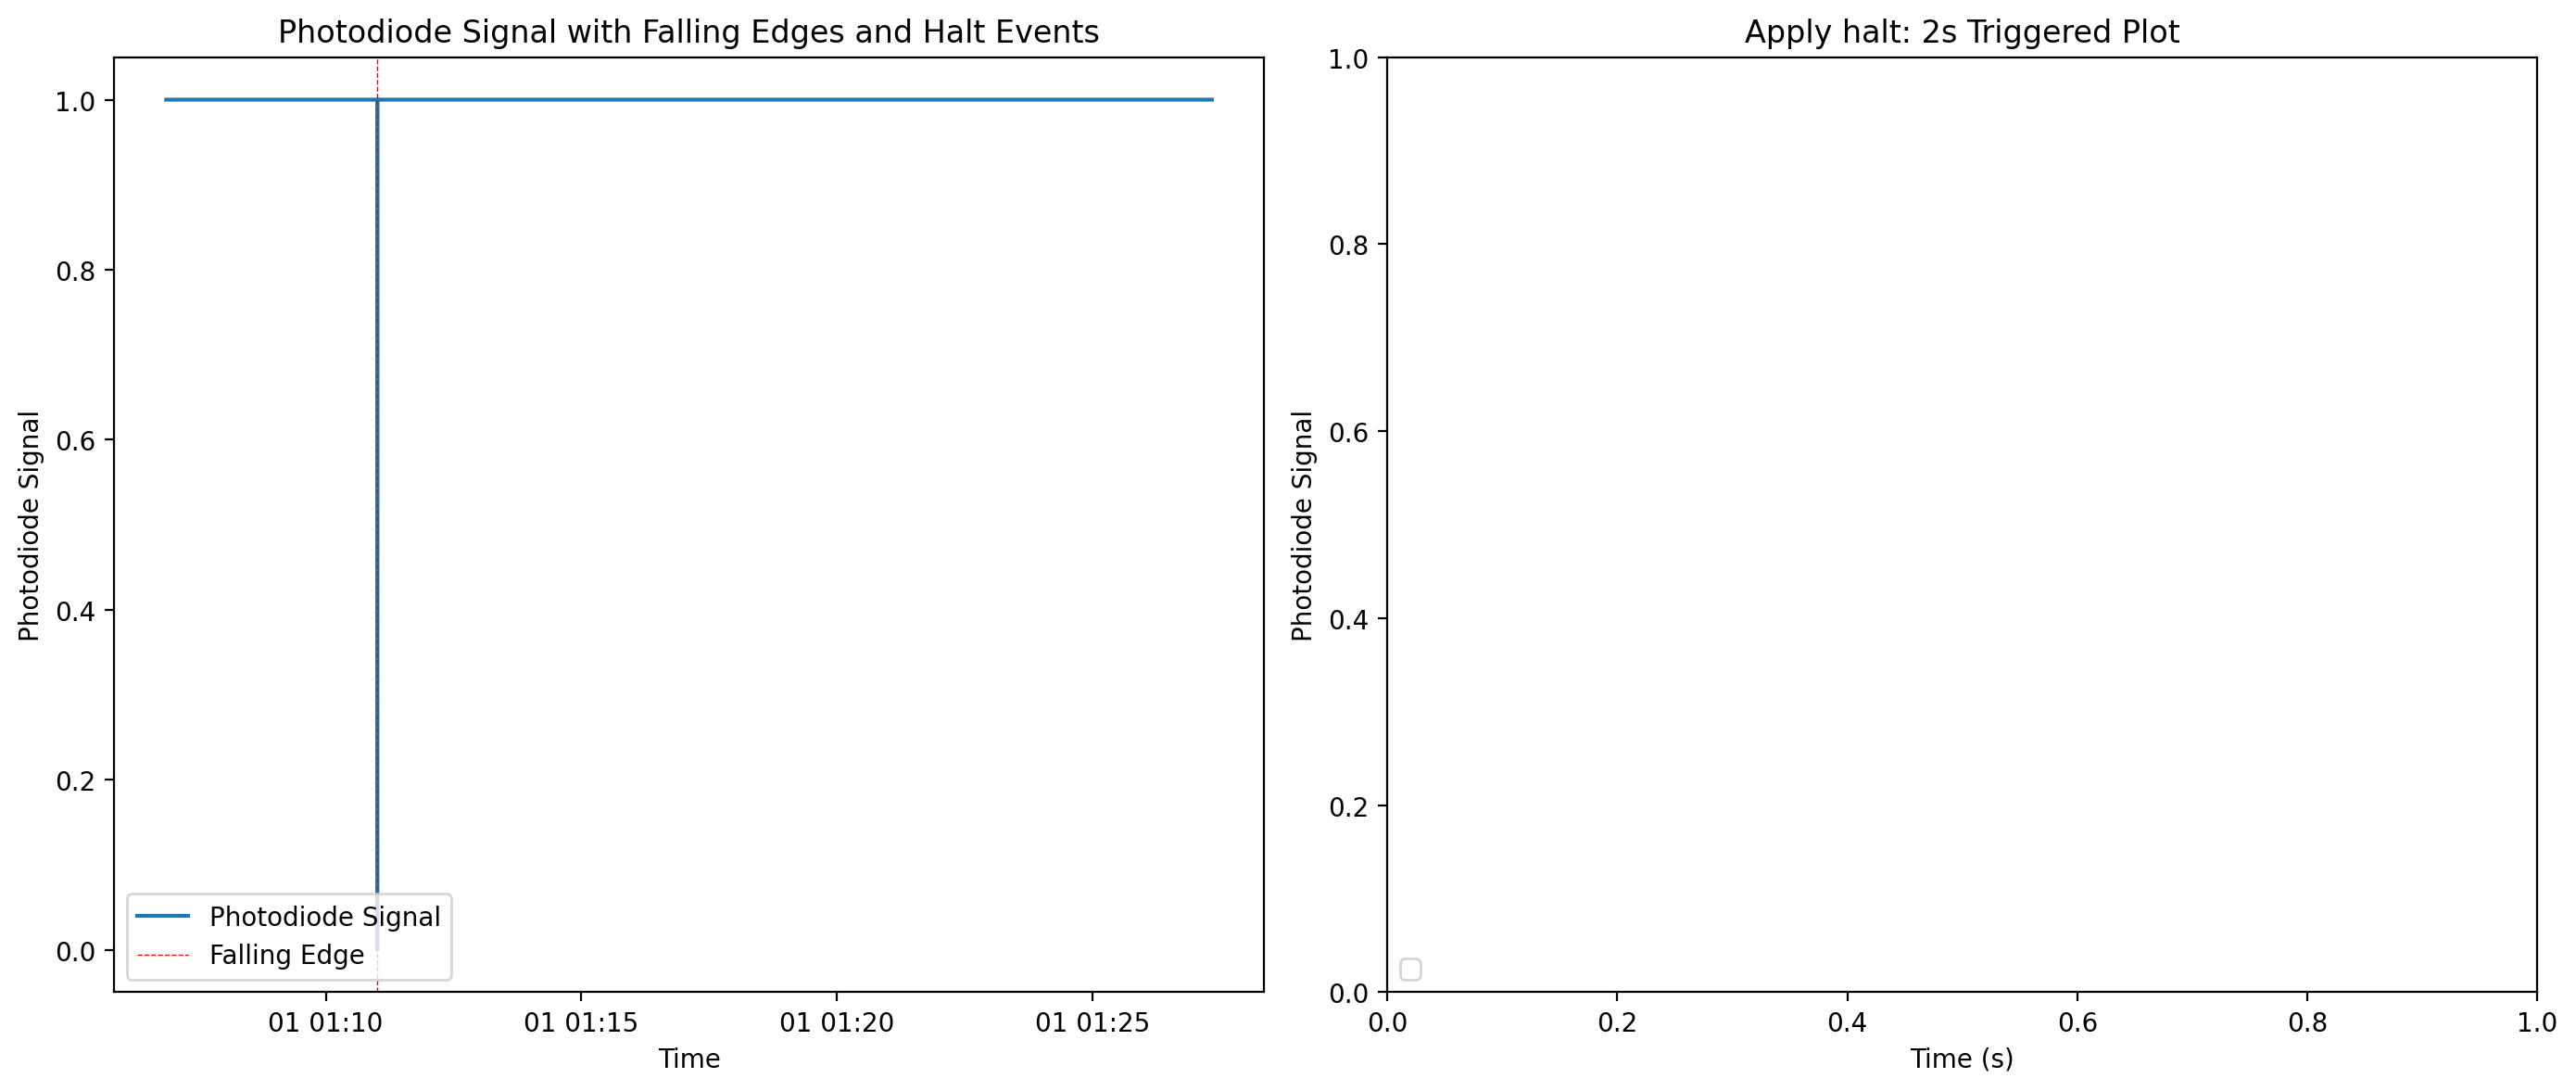

✅ 1 extra falling edges (outside 0.0ms - 0.0ms delay window) were removed before returning.
✅ Successfully analyzed photodiode signal for downsampled_data
ℹ️ INFO: skipping figure 1 for downsampled_data
✅ Completed analysis for data path: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2782-2025-04-09T13-23-36_processedData/downsampled_data

--------- Processing analysis for data path 4/4: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2783-2025-04-09T13-50-45_processedData/downsampled_data ---------
⚠️ ERROR analyzing photodiode signal: index 0 is out of bounds for axis 0 with size 0

✅ Finished analyzing all 1 successfully processed data paths


In [127]:
# create DFs and plot figure for each data path
#---------------------------------------------------
# Dictionary to store analysis results for each data path
data_path_variables = {}

for idx, data_path in enumerate(data_paths, start=1):
    print(f"\n--------- Processing analysis for data path {idx}/{len(data_paths)}: {data_path} ---------")
    
    # Skip if data wasn't successfully loaded for this path
    if data_path not in loaded_data:
        print(f"⚠️ Skipping analysis for {data_path} - data not loaded successfully")
        continue
    
    try:
        # Extract data from loaded_data dictionary
        photometry_tracking_encoder_data = loaded_data[data_path]["photometry_tracking_encoder_data"]
        camera_photodiode_data = loaded_data[data_path]["camera_photodiode_data"]
        experiment_events = loaded_data[data_path]["experiment_events"]
        mouse_name = loaded_data[data_path]["mouse_name"]
        session_name = f"{mouse_name}_{data_path.name}"  # Assuming session_name is constructed this way
        
        # Create dataframe to analyze
        df_to_analyze = photometry_tracking_encoder_data["Photodiode_int"]  # Using downsampled values in common time grid
        # df_to_analyze = camera_photodiode_data["Photodiode"]  # Use async raw values if needed for troubleshooting
        
        # Determine halt times based on different conditions
        if vestibular_mismatch or event_name == "No halt":  # Determine halt times based on experiment events
            events_matching_name = experiment_events[experiment_events["Event"] == event_name]
            if events_matching_name.empty:
                print(f"⚠️ WARNING: No events found with name '{event_name}', skipping this data path")
                continue
                
            photodiode_halts = events_matching_name.index.tolist()
            nearest_indices = photometry_tracking_encoder_data.index.get_indexer(photodiode_halts, method='nearest')
            photodiode_halts = photometry_tracking_encoder_data.index[nearest_indices]  # Align to downsampled data time grid
            print(f"ℹ️ INFO: vestibular MM or 'No halt', no signal in the photodiode, using experiment events for MM times")
            photodiode_delay_min = photodiode_delay_avg = photodiode_delay_max = None
        else:  # Determine exact halt times based on photodiode signal
            try:
                photodiode_halts, photodiode_delay_min, photodiode_delay_avg, photodiode_delay_max = process.analyze_photodiode(
                    df_to_analyze, experiment_events, event_name, plot=True
                )
                print(f"✅ Successfully analyzed photodiode signal for {data_path.name}")
            except Exception as e:
                print(f"⚠️ ERROR analyzing photodiode signal: {str(e)}")
                continue
        
        # Store analysis results
        data_path_variables[data_path] = {
            "photodiode_halts": photodiode_halts,
            "photodiode_delay_min": photodiode_delay_min,
            "photodiode_delay_avg": photodiode_delay_avg,
            "photodiode_delay_max": photodiode_delay_max,
            "session_name": session_name
        }
        
        # Plot figure if requested
        if plot_fig1:
            try:
                process.plot_figure_1(
                    photometry_tracking_encoder_data, 
                    session_name, 
                    save_path, 
                    common_resampled_rate, 
                    photodiode_halts, 
                    save_figure=True, 
                    show_figure=True, 
                    downsample_factor=50
                )
                print(f"✅ Successfully created figure 1 for {data_path.name}")
            except Exception as e:
                print(f"⚠️ ERROR creating figure 1: {str(e)}")
        else:
            print(f"ℹ️ INFO: skipping figure 1 for {data_path.name}")
        
        # Clean up to free memory
        del df_to_analyze
        gc.collect()
        
        print(f"✅ Completed analysis for data path: {data_path}")
        
    except Exception as e:
        print(f"⚠️ ERROR during analysis of {data_path}: {str(e)}")

print(f"\n✅ Finished analyzing all {len(data_path_variables)} successfully processed data paths")

In [128]:
#separates RIGHT vs LEFT TURNS, creates heatmaps, and comprehensive (Mean +- sem) aligned data for each data path
#----------------------------------------------------
"""
Refactored photometry analysis code for processing aligned behavioral data.
Separates left vs right turns, creates heatmaps, and generates comprehensive plots.
"""
class PhotometryAnalyzer:
    """Class for analyzing photometry data with behavioral events."""
    
    # Class constants
    REQUIRED_COLUMNS = [
        "Time (s)", "Photodiode_int", "z_470", "z_560", 
        "dfF_470", "dfF_560", "Motor_Velocity", "Velocity_0X", "Velocity_0Y"
    ]
    
    FLUORESCENCE_CHANNELS = {
        'z_470': {'color': 'cornflowerblue', 'label': 'z_470'},
        'z_560': {'color': 'red', 'label': 'z_560'},
        'dfF_470': {'color': 'blue', 'label': 'dfF_470'},
        'dfF_560': {'color': 'orange', 'label': 'dfF_560'}
    }
    
    def __init__(self, time_window: Tuple[float, float] = (time_window_start, time_window_end)):
        """
        Initialize analyzer with time window parameters.
        
        Args:
            time_window: Tuple of (start, end) times relative to event (seconds)
        """
        self.time_window_start, self.time_window_end = time_window
        
    def process_aligned_data(self, df: pd.DataFrame, halt_time: pd.Timestamp) -> Optional[pd.DataFrame]:
        """
        Process a single halt event efficiently.
        
        Args:
            df: Main dataframe with photometry and behavioral data
            halt_time: Timestamp of the halt event
            
        Returns:
            Windowed dataframe or None if no data in window
        """
        window_start = halt_time + pd.Timedelta(seconds=self.time_window_start)
        window_end = halt_time + pd.Timedelta(seconds=self.time_window_end)
        mask = (df.index >= window_start) & (df.index <= window_end)
        
        if not mask.any():
            return None
        
        window = df.loc[mask].copy()
        window["Time (s)"] = (window.index - halt_time).total_seconds()
        window["Halt Time"] = halt_time
        return window
    
    def separate_turns(self, aligned_df: pd.DataFrame) -> Tuple[List[pd.Timestamp], List[pd.Timestamp]]:
        """
        Separate halt events into left and right turns based on motor velocity.
        
        Args:
            aligned_df: Aligned dataframe with all halt events
            
        Returns:
            Tuple of (left_turn_halts, right_turn_halts)
        """
        left_turn_halts = []
        right_turn_halts = []
        
        for halt in aligned_df["Halt Time"].unique():
            # Look at motor velocity in pre-event window
            subset = aligned_df[
                (aligned_df["Halt Time"] == halt) & 
                (aligned_df["Time (s)"] >= -1) & 
                (aligned_df["Time (s)"] < 0)
            ]
            
            if subset.empty:
                continue
                
            mean_velocity = subset["Motor_Velocity"].mean()
            
            if mean_velocity < 0:  # Negative = left turn
                left_turn_halts.append(halt)
            elif mean_velocity > 0:  # Positive = right turn
                right_turn_halts.append(halt)
        
        return left_turn_halts, right_turn_halts
    
    def save_turn_data(self, aligned_df: pd.DataFrame, left_turns: List, right_turns: List, 
                      session_name: str, event_name: str, output_dir: Path) -> None:
        """Save separated turn data to CSV files only if turns are detected."""
        
        # Only save left turns if there are any
        if left_turns:
            left_df = aligned_df[aligned_df["Halt Time"].isin(left_turns)]
            left_file = output_dir / f"{session_name}_{event_name}_left_turns.csv"
            left_df.to_csv(left_file, index=False, float_format='%.4f')
            print(f"Saved {len(left_turns)} left turns to {left_file}")
        else:
            print(f"No left turns detected - no CSV file saved")
        
        # Only save right turns if there are any
        if right_turns:
            right_df = aligned_df[aligned_df["Halt Time"].isin(right_turns)]
            right_file = output_dir / f"{session_name}_{event_name}_right_turns.csv"
            right_df.to_csv(right_file, index=False, float_format='%.4f')
            print(f"Saved {len(right_turns)} right turns to {right_file}")
        else:
            print(f"No right turns detected - no CSV file saved")
    
    def create_heatmap(self, pivot_data: pd.DataFrame, session_name: str, event_name: str, 
                      channel: str, save_path: Path, figsize: Tuple[int, int] = (10, 6)) -> pd.DataFrame:
        """
        Create and save normalized heatmap.
        
        Args:
            pivot_data: Pivoted data (events x time)
            session_name: Name of session
            event_name: Name of event type
            channel: Channel name (e.g., 'z_470')
            save_path: Path to save figure
            figsize: Figure size tuple
            
        Returns:
            Normalized data used for heatmap
        """
        # Baseline normalization
        baseline_cols = (pivot_data.columns >= -1) & (pivot_data.columns < 0)
        if baseline_cols.any():
            baseline_means = pivot_data.loc[:, baseline_cols].mean(axis=1)
            normalized_data = pivot_data.subtract(baseline_means, axis=0)
        else:
            normalized_data = pivot_data
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        sns.heatmap(
            normalized_data, 
            cmap="RdBu_r", 
            center=0, 
            ax=ax,
            cbar_kws={'label': f'Normalized {channel}'},
            rasterized=True
        )
        
        ax.set_title(f"Heatmap ({channel}) - {session_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Event")
        
        # Optimize y-axis ticks
        n_events = len(normalized_data.index)
        y_positions = range(0, n_events, max(1, n_events // 10))
        y_labels = [str(i+1) for i in y_positions]
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels)
        
        # Add event line at time 0
        if 0 in normalized_data.columns:
            zero_idx = list(normalized_data.columns).index(0)
            ax.axvline(zero_idx, linestyle='--', color='black', alpha=0.7)
        
        # Optimize x-axis ticks
        time_cols = normalized_data.columns
        tick_indices = [i for i, val in enumerate(time_cols) 
                       if isinstance(val, (int, float)) and val % 2 == 0]
        tick_labels = [f"{int(time_cols[i])}" for i in tick_indices]
        
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels, rotation=45)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        
        return normalized_data
    
    def create_line_collections(self, df: pd.DataFrame, channels: List[str]) -> Dict[str, LineCollection]:
        """Create line collections for individual traces."""
        line_collections = {}
        
        for channel in channels:
            lines = []
            for halt in df["Halt Time"].unique():
                subset = df[df["Halt Time"] == halt]
                time_vals = subset["Time (s)"].values
                channel_vals = subset[channel].values
                lines.append(list(zip(time_vals, channel_vals)))
            
            color = self.FLUORESCENCE_CHANNELS.get(channel, {}).get('color', 'gray')
            line_collections[channel] = LineCollection(lines, colors=color, alpha=0.3, linewidths=1)
        
        return line_collections
    
    def add_mean_sem_plot(self, ax: plt.Axes, df: pd.DataFrame, channels: List[str], 
                         turn_type: str, line_style: str = '-') -> None:
        """Add mean ± SEM traces to axis."""
        grouped = df.groupby("Time (s)")
        time_index = grouped.mean().index.values
        
        for channel in channels:
            color = self.FLUORESCENCE_CHANNELS[channel]['color']
            label = f"{turn_type} {channel}"
            
            mean_vals = grouped.mean()[channel]
            sem_vals = grouped.sem()[channel]
            
            ax.plot(time_index, mean_vals, color=color, linestyle=line_style, 
                   linewidth=2, label=label)
            ax.fill_between(time_index, mean_vals - sem_vals, mean_vals + sem_vals,
                           color=color, alpha=0.2)
    
    def create_summary_plot(self, aligned_df: pd.DataFrame, session_name: str, 
                          event_name: str, save_path: Path) -> None:
        """
        Create comprehensive summary plots comparing left vs right turns.
        
        Args:
            aligned_df: Aligned dataframe with all events
            session_name: Session identifier
            event_name: Event type name
            save_path: Path to save the plot
        """
        # Separate turns
        left_turns, right_turns = self.separate_turns(aligned_df)
        
        if not left_turns and not right_turns:
            print("No valid turns found for summary plot")
            return
        
        # Create DataFrames for each turn type
        left_df = aligned_df[aligned_df["Halt Time"].isin(left_turns)]
        right_df = aligned_df[aligned_df["Halt Time"].isin(right_turns)]
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharex=True)
        z_channels = ['z_470', 'z_560']
        
        # Left plot - Left turn traces
        if not left_df.empty:
            ax1 = axes[0]
            left_collections = self.create_line_collections(left_df, z_channels + ['Motor_Velocity'])
            
            # Add fluorescence traces
            for channel in z_channels:
                ax1.add_collection(left_collections[channel])
            
            # Add motor velocity on secondary axis
            ax1_motor = ax1.twinx()
            ax1_motor.add_collection(left_collections['Motor_Velocity'])
            ax1_motor.set_ylabel("Motor Velocity", color='slategray')
            ax1_motor.tick_params(axis='y', labelcolor='slategray')
            ax1_motor.autoscale()
            
            ax1.set_title(f'Left Turn Traces (n={len(left_turns)})')
            ax1.set_ylabel("Fluorescence (z-score)")
            ax1.axvline(0, linestyle='--', color='black', alpha=0.7)
            ax1.autoscale()
        
        # Right plot - Right turn traces  
        if not right_df.empty:
            ax2 = axes[1]
            right_collections = self.create_line_collections(right_df, z_channels + ['Motor_Velocity'])
            
            # Add fluorescence traces
            for channel in z_channels:
                ax2.add_collection(right_collections[channel])
            
            # Add motor velocity on secondary axis
            ax2_motor = ax2.twinx()
            ax2_motor.add_collection(right_collections['Motor_Velocity'])
            ax2_motor.set_ylabel("Motor Velocity", color='slategray')
            ax2_motor.tick_params(axis='y', labelcolor='slategray')
            ax2_motor.autoscale()
            
            ax2.set_title(f'Right Turn Traces (n={len(right_turns)})')
            ax2.set_ylabel("Fluorescence (z-score)")
            ax2.axvline(0, linestyle='--', color='black', alpha=0.7)
            ax2.autoscale()
        
        # Comparison plot - Mean ± SEM
        ax3 = axes[2]
        
        if not left_df.empty:
            self.add_mean_sem_plot(ax3, left_df, z_channels, "Left", '--')
        if not right_df.empty:
            self.add_mean_sem_plot(ax3, right_df, z_channels, "Right", '-')
        
        # Add motor velocity comparison
        ax3_motor = ax3.twinx()
        motor_color = 'slategray'
        
        if not left_df.empty:
            left_motor_grouped = left_df.groupby("Time (s)")
            time_idx = left_motor_grouped.mean().index.values
            mean_motor = left_motor_grouped.mean()["Motor_Velocity"]
            sem_motor = left_motor_grouped.sem()["Motor_Velocity"]
            
            ax3_motor.plot(time_idx, mean_motor, color=motor_color, linestyle='--', 
                          linewidth=1.5, label="Left Motor")
            ax3_motor.fill_between(time_idx, mean_motor - sem_motor, mean_motor + sem_motor,
                                  color=motor_color, alpha=0.2)
        
        if not right_df.empty:
            right_motor_grouped = right_df.groupby("Time (s)")
            time_idx = right_motor_grouped.mean().index.values
            mean_motor = right_motor_grouped.mean()["Motor_Velocity"]
            sem_motor = right_motor_grouped.sem()["Motor_Velocity"]
            
            ax3_motor.plot(time_idx, mean_motor, color=motor_color, linestyle='-',
                          linewidth=1.5, label="Right Motor")
            ax3_motor.fill_between(time_idx, mean_motor - sem_motor, mean_motor + sem_motor,
                                  color=motor_color, alpha=0.2)
        
        ax3_motor.set_ylabel("Motor Velocity", color=motor_color)
        ax3_motor.tick_params(axis='y', labelcolor=motor_color)
        ax3_motor.axhline(0, linestyle='--', color='gray', alpha=0.5)
        ax3_motor.legend(loc='upper right')
        
        ax3.axvline(0, linestyle='--', color='black', alpha=0.7)
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Fluorescence (z-score)")
        ax3.set_title("Mean ± SEM Comparison")
        ax3.legend(loc='upper left')
        
        # Format all x-axes
        for ax in axes:
            ax.set_xlabel("Time (s)")
        
        fig.suptitle(f"{session_name} - {event_name}")
        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        plt.ioff()
    
    def process_session(self, data_path: Path, data: Dict[str, Any], 
                       variables: Dict[str, Any], event_name: str = "halt") -> None:
        """
        Process a complete session of data.
        
        Args:
            data_path: Path to the data directory
            data: Dictionary containing loaded data
            variables: Dictionary containing analysis variables
            event_name: Name of the event type being analyzed
        """
        print(f"\n--------- Processing: {data_path} ---------")
        
        try:
            # Extract data components
            df = data["photometry_tracking_encoder_data"]
            halts = variables["photodiode_halts"]
            
            # Get session name
            session_name = variables.get("session_name")
            if not session_name:
                mouse_name = data.get("mouse_name", "unknown_mouse")
                session_name = f"{mouse_name}_{data_path.stem}"
                print(f"No session_name found, using: {session_name}")
            
            print(f"Aligning {len(halts)} events for session '{session_name}'")
            
            # Process all halt events
            aligned_data = []
            for halt_time in halts:
                window_data = self.process_aligned_data(df, halt_time)
                if window_data is not None:
                    aligned_data.append(window_data)
            
            if not aligned_data:
                print(f"No aligned data generated for {session_name}, skipping")
                return
            
            # Combine all aligned data
            aligned_df = pd.concat(aligned_data, ignore_index=True)
            
            # Create output directory
            aligned_dir = data_path.parent / "aligned_data"
            aligned_dir.mkdir(exist_ok=True)
            
            # Save main aligned data
            aligned_file = aligned_dir / f"{session_name}_{event_name}_aligned.csv"
            aligned_df.to_csv(aligned_file, index=False, float_format='%.4f')
            print(f"Saved aligned data to {aligned_file}")
            
            # Separate and save turn data
            left_turns, right_turns = self.separate_turns(aligned_df)
            self.save_turn_data(aligned_df, left_turns, right_turns, 
                              session_name, event_name, aligned_dir)
            
            # Create summary plot
            print(f"📈 Creating plots for {session_name}")
            summary_path = data_path.parent / f"{session_name}_{event_name}.pdf"
            self.create_summary_plot(aligned_df, session_name, event_name, summary_path)
            print(f"Saved summary plot to {summary_path}")
            
            # Create heatmaps if sufficient data
            unique_halts = aligned_df["Halt Time"].nunique()
            if unique_halts > 1:
                self._create_all_heatmaps(aligned_df, session_name, event_name, data_path)
            else:
                print("Insufficient data for heatmaps (need >1 event)")
            
            # Cleanup
            del aligned_data, aligned_df
            gc.collect()
            
        except Exception as e:
            print(f"ERROR processing {data_path}: {str(e)}")
            traceback.print_exc()
            gc.collect()
    
    def _create_all_heatmaps(self, aligned_df: pd.DataFrame, session_name: str, 
                           event_name: str, data_path: Path) -> None:
        """Create all heatmaps for different channels."""
        heatmap_channels = ['z_470', 'z_560', 'dfF_470', 'dfF_560']
        
        for channel in heatmap_channels:
            try:
                # Create pivot table
                pivot_data = aligned_df.pivot_table(
                    index="Halt Time", 
                    columns="Time (s)", 
                    values=channel, 
                    aggfunc='first'
                )
                
                # Create heatmap
                heatmap_path = data_path.parent / f"{session_name}_{event_name}_heatmap_{channel}.pdf"
                self.create_heatmap(pivot_data, session_name, event_name, channel, heatmap_path)
                print(f"Saved {channel} heatmap")
                
                # Cleanup
                del pivot_data
                
            except Exception as e:
                print(f"Error creating {channel} heatmap: {e}")
        
        gc.collect()


def main(data_paths: List[Path], loaded_data: Dict, data_path_variables: Dict, 
         event_name: str = "halt", time_window: Tuple[float, float] = (-5, 10)):
    """
    Main processing function.
    
    Args:
        data_paths: List of data directory paths
        loaded_data: Dictionary of loaded data for each path
        data_path_variables: Dictionary of analysis variables for each path
        event_name: Name of event type (default: "halt")
        time_window: Tuple of (start, end) times relative to event in seconds
    """
    # Initialize analyzer
    analyzer = PhotometryAnalyzer(time_window)
    
    # Process each data path
    for idx, data_path in enumerate(data_paths, start=1):
        print(f"\n{'='*60}")
        print(f"Processing {idx}/{len(data_paths)}: {data_path.name}")
        print(f"{'='*60}")
        
        if data_path not in data_path_variables:
            print(f"Skipping {data_path} - no analysis data found")
            continue
        
        if data_path not in loaded_data:
            print(f"Skipping {data_path} - no loaded data found")
            continue
        
        # Process this session
        analyzer.process_session(
            data_path, 
            loaded_data[data_path], 
            data_path_variables[data_path], 
            event_name
        )
    
    print("\n✅ Finished processing all data paths.")

In [129]:
time_window = (time_window_start, time_window_end) 
main(data_paths, loaded_data, data_path_variables, 
     event_name=event_name, time_window=time_window)


Processing 1/4: downsampled_data
Skipping /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2780-2025-04-09T12-24-43_processedData/downsampled_data - no analysis data found

Processing 2/4: downsampled_data
Skipping /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2781-2025-04-09T12-54-01_processedData/downsampled_data - no analysis data found

Processing 3/4: downsampled_data

--------- Processing: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2782-2025-04-09T13-23-36_processedData/downsampled_data ---------
Aligning 0 events for session 'B6J2782_downsampled_data'
No aligned data generated for B6J2782_downsampled_data, skipping

Processing 4/4: downsampled_data
Skipping /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1/B6J2783-2025-04-09T13-50-45_processedData/downsampled_data - no analysis data found

✅ Finished processing all data paths.


In [130]:
# BASELINING
#----------------------------------------------------
def process_aligned_data_folders(data_dirs, baseline_window, event_name=event_name, plot_width=12, create_plots=True):
    """
    Process all aligned_data folders and generate baseline plots.
    
    Parameters:
    -----------
    data_dirs : list
        List of Path objects pointing to your main data directories
    baseline_window : tuple
        Tuple of (start_time, end_time) for baseline window
    event_name : str
        Event name for file naming (default: "halt")
    plot_width : int
        Width of the plot in inches
    create_plots : bool
        Whether to create and save plots (default: True)
    """
    
    results = {
        'processed': [],
        'errors': [],
        'total_folders': 0
    }
    
    # Find all aligned_data folders
    aligned_folders = []
    for data_dir in data_dirs:
        print(f"Searching in: {data_dir}")
        # Find all aligned_data folders recursively
        found_folders = list(data_dir.rglob("aligned_data"))
        aligned_folders.extend(found_folders)
        print(f"  Found {len(found_folders)} aligned_data folders")
    
    results['total_folders'] = len(aligned_folders)
    print(f"\nTotal aligned_data folders found: {len(aligned_folders)}")
    
    for aligned_folder in aligned_folders:
        try:
            print(f"\n📁 Processing folder: {aligned_folder}")
            
            # Find only the original aligned CSV files (exclude already processed baselined files and turn files)
            all_csv_files = list(aligned_folder.glob("*.csv"))
            csv_files = [f for f in all_csv_files if not f.name.endswith('_baselined_data.csv') 
                        and not f.name.endswith('_left_turns.csv') 
                        and not f.name.endswith('_right_turns.csv')]
            
            if not csv_files:
                print(f"  ⚠️  No original aligned CSV files found in {aligned_folder}")
                print(f"  Available files: {[f.name for f in all_csv_files]}")
                results['errors'].append({
                    'folder': str(aligned_folder),
                    'error': 'No original aligned CSV files found',
                    'status': 'skipped'
                })
                continue
            print(f"  Found {len(csv_files)} aligned CSV files to process")
            
            for csv_file in csv_files:
                try:
                    # Check if the CSV file name matches the event name
                    if event_name not in csv_file.name:
                        print(f"    ⚠️ Skipping {csv_file.name} as it does not match the event name '{event_name}'")
                        continue
                    
                    print(f"    📊 Processing: {csv_file.name}")
                    
                    # Load the data
                    aligned_df = pd.read_csv(csv_file)
                    
                    # Create aligned DataFrames for left and right turns
                    # Replace '_aligned' with '_left_turns' and '_right_turns'
                    left_turns_csv = csv_file.with_name(csv_file.stem.replace('_aligned', '_left_turns') + ".csv")
                    right_turns_csv = csv_file.with_name(csv_file.stem.replace('_aligned', '_right_turns') + ".csv")
                    
                    left_turns_df = None
                    right_turns_df = None
                    
                    if left_turns_csv.exists():
                        print(f"    📂 Found left turns CSV: {left_turns_csv.name}")
                        left_turns_df = pd.read_csv(left_turns_csv)
                    else:
                        print(f"    ⚠️ Left turns CSV not found: {left_turns_csv.name}")
                    
                    if right_turns_csv.exists():
                        print(f"    📂 Found right turns CSV: {right_turns_csv.name}")
                        right_turns_df = pd.read_csv(right_turns_csv)
                    else:
                        print(f"    ⚠️ Right turns CSV not found: {right_turns_csv.name}")
                    
                    # Clean up the mouse name (remove extra suffixes)
                    mouse_name = csv_file.stem.replace('_aligned', '').replace('_downsampled_data_Apply halt: 2s', '').split('_')[0]
                    # Get session name from the folder structure
                    session_name = aligned_folder.parent.name
                    
                    # Check if required columns exist
                    required_columns = ["Time (s)", "Halt Time", "z_470", "z_560", "Motor_Velocity", 
                                      "Velocity_0X", "Velocity_0Y", "Photodiode_int"]
                    missing_columns = [col for col in required_columns if col not in aligned_df.columns]
                    
                    if missing_columns:
                        print(f"    ⚠️  Missing columns: {missing_columns}")
                        print(f"    Available columns: {list(aligned_df.columns)}")
                        raise ValueError(f"Missing required columns: {missing_columns}")
                    
                    # Process the data and create plot
                    fig = baseline_aligned_data_simple(
                        aligned_df=aligned_df,
                        left_turns_df=left_turns_df,
                        right_turns_df=right_turns_df,
                        baseline_window=baseline_window,
                        mouse_name=mouse_name,
                        session_name=session_name,
                        event_name=event_name,
                        output_folder=aligned_folder,
                        csv_file=csv_file,
                        plot_width=plot_width,
                        create_plots=create_plots
                    )
                    
                    results['processed'].append({
                        'file': str(csv_file),
                        'mouse_name': mouse_name,
                        'session_name': session_name,
                        'folder': str(aligned_folder),
                        'status': 'success'
                    })
                    
                except Exception as e:
                    error_info = {
                        'file': str(csv_file),
                        'error': str(e),
                        'status': 'failed'
                    }
                    results['errors'].append(error_info)
                    print(f"    ❌ Error processing {csv_file.name}: {str(e)}")
                    
        except Exception as e:
            error_info = {
                'folder': str(aligned_folder),
                'error': str(e),
                'status': 'failed'
            }
            results['errors'].append(error_info)
            print(f"❌ Error accessing {aligned_folder}: {str(e)}")
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"PROCESSING SUMMARY")
    print(f"{'='*60}")
    print(f"Total aligned_data folders: {results['total_folders']}")
    print(f"Successfully processed files: {len(results['processed'])}")
    print(f"Errors encountered: {len(results['errors'])}")
    
    if results['errors']:
        print(f"\nErrors:")
        for error in results['errors']:
            if 'file' in error:
                print(f"  - File {Path(error['file']).name}: {error['error']}")
            else:
                print(f"  - Folder {Path(error['folder']).name}: {error['error']}")
    
    if results['processed']:
        print(f"\nSuccessfully processed:")
        for proc in results['processed']:
            print(f"  - {proc['mouse_name']} in {Path(proc['folder']).parent.name}")
    
    return results

def baseline_aligned_data_simple(aligned_df, left_turns_df, right_turns_df, baseline_window, mouse_name, session_name, event_name, output_folder, csv_file, plot_width=12, create_plots=True):
    """
    Simple baseline correction and plotting function.
    
    Parameters:
    -----------
    aligned_df : pd.DataFrame
        Main aligned data
    left_turns_df : pd.DataFrame or None
        Left turns data
    right_turns_df : pd.DataFrame or None
        Right turns data
    baseline_window : tuple
        Tuple of (start_time, end_time) for baseline window
    mouse_name : str
        Mouse name for file naming
    session_name : str
        Session name for file naming
    event_name : str
        Event name for file naming
    output_folder : Path
        Output folder path
    csv_file : Path
        Original CSV file path
    plot_width : int
        Width of the plot in inches
    create_plots : bool
        Whether to create and save plots (default: True)
    """
    
    print(f"      🔄 Performing baseline correction...")

    def baseline_dataframe(df, baseline_window, mouse_name, event_name, output_folder, suffix=""):
        """Helper function to baseline a single dataframe"""
        # Make a copy to avoid modifying the original data
        df_copy = df.copy()
        
        # Calculate baseline values
        baseline_df = df_copy[
            (df_copy["Time (s)"] >= baseline_window[0]) & 
            (df_copy["Time (s)"] <= baseline_window[1])
        ].groupby("Halt Time").mean(numeric_only=True)
        
        # Create baseline-corrected columns
        for signal_name in ["z_470", "z_560", "Motor_Velocity", "Velocity_0X", "Velocity_0Y"]:
            if signal_name in df_copy.columns:
                df_copy[f"{signal_name}_Baseline"] = df_copy[signal_name] - df_copy["Halt Time"].map(baseline_df[signal_name])
            else:
                print(f"      ⚠️  Column {signal_name} not found in {suffix} data, skipping...")
        
        # Define the baseline data file path
        if suffix:
            baseline_data_file = output_folder / f"{mouse_name}_{event_name}_{suffix}_baselined_data.csv"
        else:
            baseline_data_file = output_folder / f"{mouse_name}_{event_name}_baselined_data.csv"
        
        # Save the baseline-corrected data
        df_copy.to_csv(baseline_data_file, index=False)
        print(f"      💾 Saved {suffix} baseline data to: {baseline_data_file.name}")
        
        return df_copy

    # ---------------- Baseline Correction ----------------
    # Process main aligned data
    aligned_df_baselined = baseline_dataframe(aligned_df, baseline_window, mouse_name, event_name, output_folder)
    
    # Process left turns data if available
    left_turns_df_baselined = None
    if left_turns_df is not None:
        print(f"      🔄 Processing left turns data...")
        left_turns_df_baselined = baseline_dataframe(left_turns_df, baseline_window, mouse_name, event_name, output_folder, "left_turns")
    
    # Process right turns data if available
    right_turns_df_baselined = None
    if right_turns_df is not None:
        print(f"      🔄 Processing right turns data...")
        right_turns_df_baselined = baseline_dataframe(right_turns_df, baseline_window, mouse_name, event_name, output_folder, "right_turns")

    # ---------------- Mean and SEM for plotting (using main aligned data) ----------------
    # Select only numeric columns for aggregation
    numeric_columns = aligned_df_baselined.select_dtypes(include=['number']).columns
    mean_baseline_df = aligned_df_baselined.groupby("Time (s)")[numeric_columns].mean()
    sem_baseline_df = aligned_df_baselined.groupby("Time (s)")[numeric_columns].sem()

    def get_symmetric_ylim(mean_data, sem_data):
        max_abs_value = max(
            abs(mean_data).max() + sem_data.max(),
            abs(mean_data).min() - sem_data.min()
        )
        return (-max_abs_value, max_abs_value)

    if create_plots:
        print(f"      📊 Creating plot...")

        # ---------------- Plotting ----------------
        fig, ax = plt.subplots(figsize=(plot_width, 6))

        # Photodiode
        ax.plot(mean_baseline_df.index, mean_baseline_df["Photodiode_int"], color='grey', alpha=0.8, linewidth=2)
        ax.fill_between(mean_baseline_df.index,
                        mean_baseline_df["Photodiode_int"] - sem_baseline_df["Photodiode_int"],
                        mean_baseline_df["Photodiode_int"] + sem_baseline_df["Photodiode_int"],
                        color='grey', alpha=0.2)

        ax.set_xlabel('Time (s) relative to halt')
        ax.set_ylabel('Photodiode', color='grey')
        ax.set_title(f'Baselined Signals - {mouse_name} ({session_name})')

        # z_470 and z_560 (Fluorescence)
        ax2 = ax.twinx()
        ax2.plot(mean_baseline_df.index, mean_baseline_df["z_470_Baseline"], color='green', alpha=0.8, linewidth=2, label='470nm')
        ax2.fill_between(mean_baseline_df.index,
                         mean_baseline_df["z_470_Baseline"] - sem_baseline_df["z_470_Baseline"],
                         mean_baseline_df["z_470_Baseline"] + sem_baseline_df["z_470_Baseline"],
                         color='green', alpha=0.2)
        ax2.plot(mean_baseline_df.index, mean_baseline_df["z_560_Baseline"], color='red', alpha=0.8, linewidth=2, label='560nm')
        ax2.fill_between(mean_baseline_df.index,
                         mean_baseline_df["z_560_Baseline"] - sem_baseline_df["z_560_Baseline"],
                         mean_baseline_df["z_560_Baseline"] + sem_baseline_df["z_560_Baseline"],
                         color='red', alpha=0.2)
        ax2.set_ylabel('Fluorescence (z-score)', color='green')
        ax2.set_ylim(get_symmetric_ylim(
            pd.concat([mean_baseline_df["z_470_Baseline"], mean_baseline_df["z_560_Baseline"]]),
            pd.concat([sem_baseline_df["z_470_Baseline"], sem_baseline_df["z_560_Baseline"]])
        ))
        ax2.yaxis.label.set_color('green')

        # Motor velocity
        ax3 = ax.twinx()
        ax3.spines['right'].set_position(('outward', 50))
        ax3.plot(mean_baseline_df.index, mean_baseline_df["Motor_Velocity_Baseline"], color='#00008B', alpha=0.8, linewidth=2)
        ax3.fill_between(mean_baseline_df.index,
                         mean_baseline_df["Motor_Velocity_Baseline"] - sem_baseline_df["Motor_Velocity_Baseline"],
                         mean_baseline_df["Motor_Velocity_Baseline"] + sem_baseline_df["Motor_Velocity_Baseline"],
                         color='#00008B', alpha=0.2)
        ax3.set_ylabel('Motor Velocity (deg/s²)', color='#00008B')
        ax3.set_ylim(get_symmetric_ylim(mean_baseline_df["Motor_Velocity_Baseline"], sem_baseline_df["Motor_Velocity_Baseline"]))
        ax3.yaxis.label.set_color('#00008B')

        # Running velocity (Velocity_0X)
        ax4 = ax.twinx()
        ax4.spines['right'].set_position(('outward', 100))
        ax4.plot(mean_baseline_df.index, mean_baseline_df["Velocity_0X_Baseline"] * 1000, color='orange', alpha=0.8, linewidth=2)
        ax4.fill_between(mean_baseline_df.index,
                         (mean_baseline_df["Velocity_0X_Baseline"] - sem_baseline_df["Velocity_0X_Baseline"]) * 1000,
                         (mean_baseline_df["Velocity_0X_Baseline"] + sem_baseline_df["Velocity_0X_Baseline"]) * 1000,
                         color='orange', alpha=0.2)
        ax4.set_ylabel('Running velocity (mm/s²)', color='orange')
        ax4.set_ylim(get_symmetric_ylim(mean_baseline_df["Velocity_0X_Baseline"] * 1000, sem_baseline_df["Velocity_0X_Baseline"] * 1000))
        ax4.yaxis.label.set_color('orange')

        # Turning velocity (Velocity_0Y)
        ax5 = ax.twinx()
        ax5.spines['right'].set_position(('outward', 150))
        ax5.plot(mean_baseline_df.index, mean_baseline_df["Velocity_0Y_Baseline"], color='#4682B4', alpha=0.8, linewidth=2)
        ax5.fill_between(mean_baseline_df.index,
                         mean_baseline_df["Velocity_0Y_Baseline"] - sem_baseline_df["Velocity_0Y_Baseline"],
                         mean_baseline_df["Velocity_0Y_Baseline"] + sem_baseline_df["Velocity_0Y_Baseline"],
                         color='#4682B4', alpha=0.2)
        ax5.set_ylabel('Turning velocity (deg/s²)', color='#4682B4')
        ax5.set_ylim(get_symmetric_ylim(mean_baseline_df["Velocity_0Y_Baseline"], sem_baseline_df["Velocity_0Y_Baseline"]))
        ax5.yaxis.label.set_color('#4682B4')

        # Add vertical line at event time (t=0)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

        fig.tight_layout()

        figure_file = output_folder / f"{session_name}_{event_name}_baselined.pdf"

        # Save the figure
        fig.savefig(figure_file, format='pdf', bbox_inches='tight')
        print(f"      💾 Saved plot to: {figure_file.name}")
        plt.close(fig)
        return fig
    else:
        return None



In [131]:
# baseline usage:
if __name__ == "__main__":
    # Process all aligned_data folders
    results = process_aligned_data_folders(
        data_dirs=data_dirs,
        baseline_window=baseline_window,
        event_name=event_name,
        plot_width=plot_width,
        create_plots=True  # Ensure this is set to True to save plots
    )
    
    print(f"\n🎉 Processing complete!")

Searching in: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Training_day1
  Found 0 aligned_data folders

Total aligned_data folders found: 0

PROCESSING SUMMARY
Total aligned_data folders: 0
Successfully processed files: 0
Errors encountered: 0

🎉 Processing complete!
